# 주제 : 추천 시스템 - 영화 데이터셋과 Rating Matrix를 활용하여 추천 모델 
----------



    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    
- 데이터 출처: https://grouplens.org/datasets/movielens/


## 최종 목표
    - CF(Collaborative Filtering) 기반 추천 모델의 이해
    - Matrix Factorization 기반 추천 모델의 이해
    - KNN, SVD 알고리즘에 대한 이해
    - 훈련된 모델의 결과를 해석하는 방법 습득
    - 모델의 추천 결과를 평가하는 방법 습득



## Step 1. 데이터 전처리 과정

### 데이터 불러오기

In [2]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
rating_df # time은 Unix time -> 커지면 커질 수록 현재에 가까워짐

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [5]:
movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')
movie_df.head()



,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


###  EDA - 사용자 수와 영화의 수 탐색

In [6]:
rating_df['user_id'].unique()# unique() 함수로 사용자 수와 영화 수 탐색

array([   1,    2,    3, ..., 6038, 6039, 6040], dtype=int64)

### 유저수 확인

In [7]:
len(rating_df['user_id'].unique())   #

6040

### 영화수 확인

In [8]:
len(rating_df['movie_id'].unique())

3706

###  EDA - 영화 평가 점수의 분포 탐색

In [9]:
# hist() 함수로 히스토그램 그래프 생성

In [10]:
import matplotlib.pyplot as plt

In [ ]:
rating_df['rating'].hist()

## Step 2. CF-based 모델링 (KNN)

### Rating Matrix와 Colaborative Filtering (CF)
----------

#### Rating Matrix

![rating matrix](https://www.researchgate.net/profile/Giuseppe_Manco3/publication/220907096/figure/fig1/AS:305570830667776@1449865171054/An-example-of-rating-matrix.png)

    1. User를 Row, Item을 Column으로 하며 Value를 Rating으로 하는 행렬
    2. Rating의 종류
      - Explicit Feedback : 영화 점수, 리뷰 점수, 좋아요 표시...
      - Implicit Feedback : 조회, 시청, 구매, 찜 표시...
    3. Rating Matrix를 추천 모델로 활용하는 방법
      - Colaborative Filtering (CF)
      - Matrix Factorization (MF)

-----

#### Colaborative Filtering (CF)

![CF](https://t1.daumcdn.net/cfile/tistory/9970CE495AF71C0C06)

> 고객들의 선호도와 관심 표현을 바탕으로 선호도, 관심에서 비슷한 패턴을 가진 고객들을 식별해 내는 기법이다. 비슷한 취향을 가진 고객들에게 서로 아직 구매하지 않은 상품들은 교차 추천하거나 분류된 고객의 취향이나 생활 형태에 따라 관련 상품을 추천하는 형태의 서비스를 제공하기 위해 사용된다.
    
    1. User-based
    2. Item-based

-----

### 모델링 - Train/Test 데이터 분리

In [ ]:
conda install -c conda-forge scikit-surprise

In [15]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

In [16]:
reader

In [17]:
data

###  모델링 - KNN 모델 학습

-----

#### KNN (K-Nearest Neighbor) 알고리즘

![knn](http://i.imgur.com/gLBo1gX.png)

    [KNN의 대략적인 이해]
    1. 새로운(혹은 특정한) 데이터 포인트 X가 있을 때, X와 가장 유사한 k개를 이용하여 데이터 포인트 X의 위치를 찾는 알고리즘
    2. euclidean distance, cosine similarity 등을 기준으로 유사한 k개를 계산
    3. 분류(classification) 문제의 경우는 k개의 포인트에서 가장 많이 등장한 class로 할당
    4. 예측(regression) 문제의 경우는 k개 포인트의 평균 값, 혹은 가중치 값 등으로 X의 값을 예측

#### Surprise의 KNN

> A basic collaborative filtering algorithm. The prediction 𝑟̂ 𝑢𝑖 is set as

![suprise knn](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/knn.png)

###### (https://surprise.readthedocs.io/en/stable/knn_inspired.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. User-based CF
    2. 유저 A와 가장 영화를 유사하게 평가한 유저 k명을 선정
    3. k명의 유저가 영화 a를 평가한 점수를 활용하여 위의 식대로 점수를 계산함
    4. 이와 같은 방식으로 Rating Matrix를 완성
-----
    [Similarity]
    1. 가장 일반적인 Similarity 계산 방식은 cosine similarity
    2. 다른 방식은 euclidean distance, jaccard index, pearson correlation 등이 있음

![cosine](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/cosine.png)
-----

### 0.9 ,0.8 등등은  similarity(A,B)임

In [ ]:
# KNN 이해를 돕기 위한 참고 코드
ab = (0.9 * 4) + (0.8 * 3) + (0.7 * 5) + (0.6 * 1)  
bb = (0.9) + 0.8 + 0.7 + 0.6

ab/bb

In [18]:
from surprise import KNNBasic
from surprise import accuracy
algo=KNNBasic(k=40,min_k=1,sim_options={'user_based':True,'name':'cosine'})
algo.fit(trainset)
predictions=algo.test(testset)

# KNNBasic 모델 학습

Computing the cosine similarity matrix...
Done computing similarity matrix.


###  모델링 - RMSE 평가

In [19]:
from surprise import accuracy
accuracy.rmse(predictions)

# accuracy로 rmse 평가

RMSE: 0.9744


0.974433435653238

###  모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [20]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
predictions = algo.test(testset[:20])

In [21]:
predictions

[Prediction(uid=3612, iid=292, r_ui=3.0, est=3.7249661178354025, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3401, iid=2524, r_ui=3.0, est=3.2263756821079737, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=4937, iid=1880, r_ui=4.0, est=3.3925639163901273, details={'actual_k': 18, 'was_impossible': False}),
 Prediction(uid=39, iid=24, r_ui=4.0, est=3.2227123376135385, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3082, iid=2739, r_ui=3.0, est=4.147259661769735, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=4126, iid=1951, r_ui=4.0, est=3.874274805635961, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3650, iid=1391, r_ui=1.0, est=3.174956128918739, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5029, iid=1682, r_ui=4.0, est=3.8738609033637204, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2462, iid=1220, r_ui=4.0, est=4.124982958825778,

## Step 3. MF-based 모델링 (SVD)

###  모델링 - Train/Test 데이터 분리

In [22]:
# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리

reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(rating_df[['user_id','movie_id','rating']],reader)
trainset,testset=train_test_split(data,test_size=.25)

### 모델링 - SVD 모델 학습

-----

#### Matrix Factorization의 개념

![MF](https://t1.daumcdn.net/cfile/tistory/99EAC1455AF71F3E31)

![MF2](https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-3-319-65930-5_47/MediaObjects/455696_1_En_47_Fig3_HTML.gif)

    [MF의 대략적인 이해]
    1. 원래의 행렬을 다른 2개 행렬로 분해하고, 이를 다시 원래 모양으로 만드는 과정을 Factorization 이라고 함.
    2. 그 과정에서 Latent Factor 라는 것을 활용하여, 행과 열의 성질을 만들어낼 수 있음.
    3. latent factor를 충분히 많이 만들게 되면, 유저와 아이템의 성질을 벡터로 표현 가능.
    4. 일반적으로 지도 학습을 통해 P와 Q를 찾게 되고, 이를 Model-based CF 라고 하기도 함.

#### Surprise의 SVD

> The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization

> The prediction 𝑟̂ 𝑢𝑖 is set as:

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_1.png)

###### (https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. Model-based MF
    2. 이미 점수가 존재하는 r_ui를 기준으로 P, Q를 학습.
    3. 특정 epoch, 혹은 수렴 조건에 달할 때 까지 학습 (Gradient Descent)

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_2.png)

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_3.png)

-----

### 결국 지도학습을을 통해 P(BOB,marie - 유저 관련 벡터)와 Q를 찾는과정임

In [64]:
from surprise import SVD
from surprise import accuracy

algo=SVD()
algo.fit(trainset)
predictions=algo.test(testset)
# SVD 모델 학습

###  모델링 - RMSE 평가

In [26]:
accuracy.rmse(predictions)


#앞에서와 동일하게 accuracy 함수로 rmse 평가

RMSE: 0.8769


0.876864287413392

### 모델링 & 시각화 - RMSE를 개선하는 파라미터 튜닝 자동화

In [27]:
import time

param_list = [10,50,100,150,200]
rmse_list_by_factors=[]
ttime_list_by_factors=[]
for n in param_list:
    train_start=time.time()
    algo=SVD(n_factors=n)
    algo.fit(trainset)
    train_end=time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions=algo.test(testset)
    rmse_result=accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print('----------------------------')
print('searching n_factors is finish')
    

training time of model: 11.96 seconds
RMSE of test dataset in SVD model, n_factors=10
RMSE: 0.8793
----------------------------
training time of model: 23.63 seconds
RMSE of test dataset in SVD model, n_factors=50
RMSE: 0.8749
----------------------------
training time of model: 37.64 seconds
RMSE of test dataset in SVD model, n_factors=100
RMSE: 0.8774
----------------------------
training time of model: 52.30 seconds
RMSE of test dataset in SVD model, n_factors=150
RMSE: 0.8818
----------------------------
training time of model: 62.19 seconds
RMSE of test dataset in SVD model, n_factors=200
RMSE: 0.8830
----------------------------
searching n_factors is finish


In [15]:
import time

param_list = [10, 50, 100, 150, 200]
rmse_list_by_factors = []
time_list_by_factors = []
for n in param_list:    
    train_start = time.time()
    algo = SVD(n_factors=n)
    algo.fit(trainset)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = algo.test(testset)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 9.91 seconds
RMSE of test dataset in SVD model, n_factors=10
RMSE: 0.8771
------------------------------------
training time of model: 20.14 seconds
RMSE of test dataset in SVD model, n_factors=50
RMSE: 0.8728
------------------------------------
training time of model: 32.67 seconds
RMSE of test dataset in SVD model, n_factors=100
RMSE: 0.8751
------------------------------------
training time of model: 43.92 seconds
RMSE of test dataset in SVD model, n_factors=150
RMSE: 0.8781
------------------------------------
training time of model: 57.35 seconds
RMSE of test dataset in SVD model, n_factors=200
RMSE: 0.8809
------------------------------------
searching n_factors is finish.


### overfitting때문에 factor가늘어났을때 성능이 줄어드는 것 -> 과적합 없이 가장 성능 좋은 50이 최적

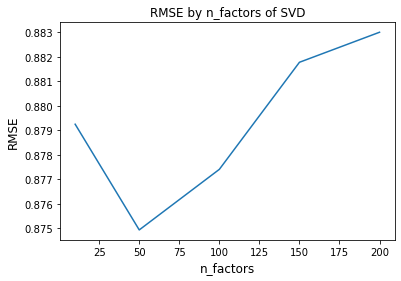

In [28]:
plt.plot(param_list, rmse_list_by_factors)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

###  모델 평가 - 최종 RMSE 평가

In [18]:
algo = SVD(n_factors=50)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8727


0.8727092962569559

### 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [19]:
predictions = algo.test(testset[:20])

for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 2529 | real rating : 5.0 | predicted rating : 3.7216363043430407
Item id 2520 | real rating : 3.0 | predicted rating : 3.129939298114628
Item id 434 | real rating : 2.0 | predicted rating : 2.691992215544172
Item id 1028 | real rating : 4.0 | predicted rating : 3.872738349442908
Item id 3072 | real rating : 3.0 | predicted rating : 3.4523459600890694
Item id 377 | real rating : 5.0 | predicted rating : 4.37653346723356
Item id 307 | real rating : 1.0 | predicted rating : 2.6282503728338873
Item id 3505 | real rating : 3.0 | predicted rating : 3.7330891215464526
Item id 1210 | real rating : 5.0 | predicted rating : 4.087455673702209
Item id 2798 | real rating : 1.0 | predicted rating : 1.3140450320755863
Item id 2995 | real rating : 2.0 | predicted rating : 2.840908289221839
Item id 2459 | real rating : 4.0 | predicted rating : 3.3087437411075116
Item id 173 | real rating : 3.0 | predicted rating : 3.04193350321482
Item id 329 | real rating : 4.0 | predicted rating : 4.283195917

## Step 4. 추천 결과 평가

-----

#### CF, MF 기반 추천시스템의 가정(한계)

    [가정 : 사용자의 과거 Preference는 미래에서도 동일하다]
    1. Time Series로 추정된 선호도가 아닌, Estimate 되거나 Factorized 된 점수
    2. A시점에 평가한 선호도와, B시점에 평가한 선호도가 동일 선에서 학습됨
    3. Test 데이터에 대한 평가 역시, 시간이 고려되지 않은 "랜덤한 빈공간 찾기" 식으로 평가됨


###  추천 결과 평가 - 사용자별 전체 시청리스트 추출

In [47]:
rating_df.groupby('user_id')[['user_id','movie_id']].apply(lambda x:x['movie_id'].tolist())

user_id
1       [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2       [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3       [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4       [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5       [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
                              ...                        
6036    [571, 574, 2053, 2054, 2058, 588, 589, 4, 3005...
6037    [589, 3006, 1407, 2064, 2065, 593, 3015, 903, ...
6038    [1419, 920, 3088, 232, 1136, 1148, 1183, 2146,...
6039    [588, 2067, 1416, 3022, 3028, 2080, 2083, 2087...
6040    [573, 589, 1, 2068, 592, 593, 3016, 3017, 2070...
Length: 6040, dtype: object

In [30]:
# groupby와 apply 함수를 이용하여 사용자별 시청리스트 추출
user_watch_dict_list=rating_df.groupby('user_id')[['user_id','movie_id']].apply(lambda x:x['movie_id'].tolist())

In [40]:
user_watch_dict_list.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
           dtype='int64', name='user_id', length=6040)

###  추천 결과 평가 - 특정 시간 기준 사용자별 Train/Test 시청리스트 추출
추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

<AxesSubplot:>

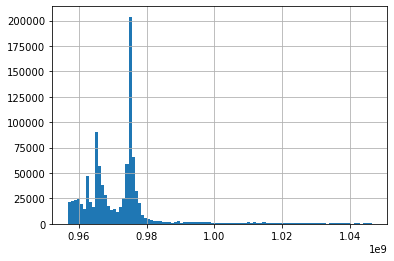

In [49]:
# 시간별 시청 분포 탐색
rating_df['time'].hist(bins=100)

In [52]:
# 8:2 로 분할할 수 있는 시간 지정
rating_df['time'].quantile(q=0.8, interpolation='nearest')

975768738

In [53]:
# 지정된 시간으로 데이터셋 분리

train_df = rating_df[rating_df['time'] < 975768738][['user_id', 'movie_id', 'rating']]
test_df = rating_df[rating_df['time'] >= 975768738][['user_id', 'movie_id', 'rating']]

In [54]:
train_df.shape
# 특정 시간 이후를 대상으로 다시 한 번 사용자별 시청리스트 추출

(800164, 3)

In [55]:
len(train_df['user_id'].unique())

5400

In [56]:
len(test_df['user_id'].unique())

1783

In [57]:
len(train_df['movie_id'].unique())

3662

In [58]:
len(test_df['movie_id'].unique())

3511

###  추천 결과 평가 - 모델 기반 사용자별 선호 시청리스트 추출

In [59]:
user_watch_dict_list_test = test_df.groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())

In [60]:
user_watch_dict_list_test

user_id
1       [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2       [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3       [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4       [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5       [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
                              ...                        
6001    [589, 1438, 965, 3481, 2875, 3147, 1552, 2917,...
6002    [3789, 3011, 1419, 3037, 902, 2098, 909, 3093,...
6016    [3795, 2062, 2065, 900, 3044, 1441, 914, 920, ...
6028                                               [3000]
6040    [2068, 953, 3421, 232, 3182, 2571, 2575, 1921,...
Length: 1783, dtype: object

In [65]:
# 위에서 추출한 학습 데이터셋으로 SVD 모델 다시 학습
data = Dataset.load_from_df(df=train_df, reader=reader)
train_data = data.build_full_trainset()
algo = SVD(n_factors=50)
algo.fit(train_data)

### anti_testsset() -> 매트릭스에서 물음표에 해당하는 부분을 찾을 수 있음

In [66]:
# anti dataset 생성
test_data = train_data.build_anti_testset()

In [67]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
predictions = algo.test(testset[:20])

In [31]:
predictions = algo.test(test_data[:20])

for uid, iid, _, predicted_rating, _ in predictions:
    print("User id", uid, "|", "Item id", iid, "|", "predicted rating :", predicted_rating)

User id 635 | Item id 2054 | predicted rating : 3.716595685356727
User id 635 | Item id 589 | predicted rating : 4.192397268677711
User id 635 | Item id 1261 | predicted rating : 3.925720729937444
User id 635 | Item id 3016 | predicted rating : 3.3522913162322445
User id 635 | Item id 1274 | predicted rating : 4.069475762177576
User id 635 | Item id 2094 | predicted rating : 3.5128415396496484
User id 635 | Item id 780 | predicted rating : 3.8162724124775327
User id 635 | Item id 1603 | predicted rating : 3.3816560488774434
User id 635 | Item id 2288 | predicted rating : 4.059280598341983
User id 635 | Item id 968 | predicted rating : 4.000051297198185
User id 635 | Item id 2451 | predicted rating : 3.1462933903202615
User id 635 | Item id 2455 | predicted rating : 3.8223491041123103
User id 635 | Item id 1653 | predicted rating : 3.9727531103525764
User id 635 | Item id 2456 | predicted rating : 2.729758720865095
User id 635 | Item id 2460 | predicted rating : 2.5764993344402973
User 

In [ ]:
predictions['uid']

In [71]:
predictions = algo.test(test_data)
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in predictions:
  if uid in estimated_unwatched_dict:
    estimated_unwatched_dict[uid].append((iid, predicted_rating))
  else:
    estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

### 문제 17. 추천 결과 평가 - 예상 선호 리스트와 실제 시청리스트로 MAP@K 계산

-----

![confusion_matrix](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/confusion_matrix.png)

    [Confusion Matrix와 Recall]
    1. 분류 문제에서 사용하는 대표적인 평가 기준
    2. 무언가의 실제 클래스(binary), 그리고 예상한 클래스(binary)를 비교하기 위한 매트릭스
    3. 이 중 Precision은 흔히 "정확도" 이라고 불리는 지표로, 맞다고 예측한 것 중에 실제로 맞는 것의 비율을 의미함.

-----

    [추천시스템과 Precision, Recall]
    1. 추천시스템에 이를 대입해보자
    2. 유저A가 실제로 시청한 영화들을 a, 모델이 유저 A가 볼 것이라고 예측한 영화들을 b라고 가정
    3. 이 때 모델이 10개의 영화를 예측 했다면 Top 10 Precision 계산할 수 있음.
    4. Recall 역시 마찬가지의 방법으로 구할 수 있음.
    5. Precision과 Recall에 대한 선택 기준은 상황마다 다르지만, 추천시스템에서 일반적으로 사용하는 지표는 "MAP"
    6. MAP(Mean Average Precision) : 추천시스템에서는 각 유저마다의 Precision을 계산한 뒤, 이것을 모든 추천 대상 유저로 확장하여 평균적인 지표를 계산한 것이라고 볼 수 있음.

In [72]:
# 4점 이상을 준 test 시청리스트 추출
user_watch_dict_list_test = test_df[test_df['rating']>=4].groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())



In [73]:
user_watch_dict_list_test 

user_id
1       [1193, 3408, 2355, 1287, 2804, 594, 919, 595, ...
2       [1357, 3068, 1537, 2194, 648, 2268, 3468, 1210...
3       [3421, 1394, 104, 2735, 1210, 1079, 1615, 1291...
4       [3468, 2951, 1214, 1036, 260, 2028, 480, 1198,...
5       [2987, 2333, 1175, 2337, 1535, 1392, 866, 2770...
                              ...                        
6001    [965, 3481, 3147, 3947, 1653, 2600, 1683, 457,...
6002    [3789, 3011, 1419, 3037, 2098, 909, 3093, 3098...
6016    [930, 2875, 3834, 3894, 3129, 339, 1639, 3245,...
6028                                               [3000]
6040    [2068, 953, 232, 3182, 2571, 2575, 1921, 1947,...
Length: 1762, dtype: object

In [76]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3
for user in estimated_unwatched_dict:
  estimated_list = estimated_unwatched_dict[user].copy()
  estimated_list.sort(key=lambda tup: tup[1], reverse=True)
  try: 
    top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
    actual_watch_list = user_watch_dict_list_test[int(user)]
    user_metric.append((user, top_k_prefer_list, actual_watch_list))
  except:
    print("list index out of range, exclude user " + str(user))

list index out of range, exclude user 636
list index out of range, exclude user 637
list index out of range, exclude user 638
list index out of range, exclude user 640
list index out of range, exclude user 642
list index out of range, exclude user 643
list index out of range, exclude user 644
list index out of range, exclude user 645
list index out of range, exclude user 647
list index out of range, exclude user 652
list index out of range, exclude user 653
list index out of range, exclude user 654
list index out of range, exclude user 655
list index out of range, exclude user 656
list index out of range, exclude user 657
list index out of range, exclude user 658
list index out of range, exclude user 659
list index out of range, exclude user 661
list index out of range, exclude user 662
list index out of range, exclude user 663
list index out of range, exclude user 665
list index out of range, exclude user 666
list index out of range, exclude user 668
list index out of range, exclude u

list index out of range, exclude user 1013
list index out of range, exclude user 1014
list index out of range, exclude user 1016
list index out of range, exclude user 1017
list index out of range, exclude user 1018
list index out of range, exclude user 1022
list index out of range, exclude user 1023
list index out of range, exclude user 1024
list index out of range, exclude user 1025
list index out of range, exclude user 1027
list index out of range, exclude user 1028
list index out of range, exclude user 1030
list index out of range, exclude user 1031
list index out of range, exclude user 1032
list index out of range, exclude user 1035
list index out of range, exclude user 1036
list index out of range, exclude user 1037
list index out of range, exclude user 1038
list index out of range, exclude user 1039
list index out of range, exclude user 1040
list index out of range, exclude user 1042
list index out of range, exclude user 1044
list index out of range, exclude user 1045
list index 

list index out of range, exclude user 1440
list index out of range, exclude user 1441
list index out of range, exclude user 1442
list index out of range, exclude user 1443
list index out of range, exclude user 1444
list index out of range, exclude user 1445
list index out of range, exclude user 1446
list index out of range, exclude user 1450
list index out of range, exclude user 1452
list index out of range, exclude user 1453
list index out of range, exclude user 1454
list index out of range, exclude user 1456
list index out of range, exclude user 1459
list index out of range, exclude user 1460
list index out of range, exclude user 1461
list index out of range, exclude user 1462
list index out of range, exclude user 1464
list index out of range, exclude user 1465
list index out of range, exclude user 1466
list index out of range, exclude user 1468
list index out of range, exclude user 1469
list index out of range, exclude user 1471
list index out of range, exclude user 1472
list index 

list index out of range, exclude user 1916
list index out of range, exclude user 1918
list index out of range, exclude user 1919
list index out of range, exclude user 1920
list index out of range, exclude user 1921
list index out of range, exclude user 1923
list index out of range, exclude user 1924
list index out of range, exclude user 1927
list index out of range, exclude user 1929
list index out of range, exclude user 1931
list index out of range, exclude user 1932
list index out of range, exclude user 1933
list index out of range, exclude user 1934
list index out of range, exclude user 1935
list index out of range, exclude user 1936
list index out of range, exclude user 1937
list index out of range, exclude user 1938
list index out of range, exclude user 1939
list index out of range, exclude user 1940
list index out of range, exclude user 1942
list index out of range, exclude user 1944
list index out of range, exclude user 1945
list index out of range, exclude user 1947
list index 

list index out of range, exclude user 2437
list index out of range, exclude user 2439
list index out of range, exclude user 2440
list index out of range, exclude user 2441
list index out of range, exclude user 2442
list index out of range, exclude user 2443
list index out of range, exclude user 2444
list index out of range, exclude user 2445
list index out of range, exclude user 2447
list index out of range, exclude user 2448
list index out of range, exclude user 2449
list index out of range, exclude user 2450
list index out of range, exclude user 2452
list index out of range, exclude user 2455
list index out of range, exclude user 2456
list index out of range, exclude user 2457
list index out of range, exclude user 2458
list index out of range, exclude user 2459
list index out of range, exclude user 2460
list index out of range, exclude user 2461
list index out of range, exclude user 2463
list index out of range, exclude user 2464
list index out of range, exclude user 2465
list index 

list index out of range, exclude user 2923
list index out of range, exclude user 2924
list index out of range, exclude user 2927
list index out of range, exclude user 2928
list index out of range, exclude user 2929
list index out of range, exclude user 2930
list index out of range, exclude user 2932
list index out of range, exclude user 2934
list index out of range, exclude user 2936
list index out of range, exclude user 2937
list index out of range, exclude user 2938
list index out of range, exclude user 2939
list index out of range, exclude user 2940
list index out of range, exclude user 2941
list index out of range, exclude user 2942
list index out of range, exclude user 2943
list index out of range, exclude user 2945
list index out of range, exclude user 2948
list index out of range, exclude user 2949
list index out of range, exclude user 2950
list index out of range, exclude user 2951
list index out of range, exclude user 2953
list index out of range, exclude user 2954
list index 

list index out of range, exclude user 3235
list index out of range, exclude user 3236
list index out of range, exclude user 3237
list index out of range, exclude user 3238
list index out of range, exclude user 3239
list index out of range, exclude user 3240
list index out of range, exclude user 3241
list index out of range, exclude user 3242
list index out of range, exclude user 3243
list index out of range, exclude user 3244
list index out of range, exclude user 3245
list index out of range, exclude user 3246
list index out of range, exclude user 3247
list index out of range, exclude user 3248
list index out of range, exclude user 3249
list index out of range, exclude user 3250
list index out of range, exclude user 3251
list index out of range, exclude user 3252
list index out of range, exclude user 3253
list index out of range, exclude user 3254
list index out of range, exclude user 3255
list index out of range, exclude user 3256
list index out of range, exclude user 3257
list index 

list index out of range, exclude user 3615
list index out of range, exclude user 3616
list index out of range, exclude user 3617
list index out of range, exclude user 3618
list index out of range, exclude user 3619
list index out of range, exclude user 3621
list index out of range, exclude user 3622
list index out of range, exclude user 3623
list index out of range, exclude user 3625
list index out of range, exclude user 3627
list index out of range, exclude user 3628
list index out of range, exclude user 3629
list index out of range, exclude user 3630
list index out of range, exclude user 3631
list index out of range, exclude user 3632
list index out of range, exclude user 3633
list index out of range, exclude user 3634
list index out of range, exclude user 3635
list index out of range, exclude user 3636
list index out of range, exclude user 3637
list index out of range, exclude user 3638
list index out of range, exclude user 3639
list index out of range, exclude user 3640
list index 

list index out of range, exclude user 4075
list index out of range, exclude user 4076
list index out of range, exclude user 4077
list index out of range, exclude user 4078
list index out of range, exclude user 4080
list index out of range, exclude user 4081
list index out of range, exclude user 4082
list index out of range, exclude user 4083
list index out of range, exclude user 4086
list index out of range, exclude user 4087
list index out of range, exclude user 4088
list index out of range, exclude user 4090
list index out of range, exclude user 4091
list index out of range, exclude user 4092
list index out of range, exclude user 4093
list index out of range, exclude user 4095
list index out of range, exclude user 4096
list index out of range, exclude user 4097
list index out of range, exclude user 4098
list index out of range, exclude user 4099
list index out of range, exclude user 4100
list index out of range, exclude user 4101
list index out of range, exclude user 4102
list index 

list index out of range, exclude user 4373
list index out of range, exclude user 4374
list index out of range, exclude user 4375
list index out of range, exclude user 4376
list index out of range, exclude user 4377
list index out of range, exclude user 4378
list index out of range, exclude user 4379
list index out of range, exclude user 4380
list index out of range, exclude user 4381
list index out of range, exclude user 4382
list index out of range, exclude user 4383
list index out of range, exclude user 4385
list index out of range, exclude user 4388
list index out of range, exclude user 4389
list index out of range, exclude user 4390
list index out of range, exclude user 4391
list index out of range, exclude user 4392
list index out of range, exclude user 4393
list index out of range, exclude user 4394
list index out of range, exclude user 4395
list index out of range, exclude user 4396
list index out of range, exclude user 4397
list index out of range, exclude user 4398
list index 

list index out of range, exclude user 4948
list index out of range, exclude user 4949
list index out of range, exclude user 4952
list index out of range, exclude user 4953
list index out of range, exclude user 4954
list index out of range, exclude user 4955
list index out of range, exclude user 4956
list index out of range, exclude user 4957
list index out of range, exclude user 4959
list index out of range, exclude user 4961
list index out of range, exclude user 4962
list index out of range, exclude user 4963
list index out of range, exclude user 4964
list index out of range, exclude user 4965
list index out of range, exclude user 4966
list index out of range, exclude user 4967
list index out of range, exclude user 4968
list index out of range, exclude user 4969
list index out of range, exclude user 4970
list index out of range, exclude user 4971
list index out of range, exclude user 4972
list index out of range, exclude user 4973
list index out of range, exclude user 4974
list index 

list index out of range, exclude user 5201
list index out of range, exclude user 5202
list index out of range, exclude user 5203
list index out of range, exclude user 5204
list index out of range, exclude user 5206
list index out of range, exclude user 5207
list index out of range, exclude user 5209
list index out of range, exclude user 5210
list index out of range, exclude user 5211
list index out of range, exclude user 5212
list index out of range, exclude user 5213
list index out of range, exclude user 5214
list index out of range, exclude user 5215
list index out of range, exclude user 5216
list index out of range, exclude user 5217
list index out of range, exclude user 5218
list index out of range, exclude user 5219
list index out of range, exclude user 5220
list index out of range, exclude user 5221
list index out of range, exclude user 5223
list index out of range, exclude user 5224
list index out of range, exclude user 5225
list index out of range, exclude user 5226
list index 

list index out of range, exclude user 5639
list index out of range, exclude user 5640
list index out of range, exclude user 5641
list index out of range, exclude user 5642
list index out of range, exclude user 5645
list index out of range, exclude user 5646
list index out of range, exclude user 5647
list index out of range, exclude user 5648
list index out of range, exclude user 5649
list index out of range, exclude user 5651
list index out of range, exclude user 5652
list index out of range, exclude user 5655
list index out of range, exclude user 5656
list index out of range, exclude user 5658
list index out of range, exclude user 5659
list index out of range, exclude user 5660
list index out of range, exclude user 5661
list index out of range, exclude user 5662
list index out of range, exclude user 5663
list index out of range, exclude user 5664
list index out of range, exclude user 5665
list index out of range, exclude user 5666
list index out of range, exclude user 5667
list index 

list index out of range, exclude user 6011
list index out of range, exclude user 6012
list index out of range, exclude user 6013
list index out of range, exclude user 6014
list index out of range, exclude user 6015
list index out of range, exclude user 6017
list index out of range, exclude user 6018
list index out of range, exclude user 6019
list index out of range, exclude user 6020
list index out of range, exclude user 6021
list index out of range, exclude user 6022
list index out of range, exclude user 6023
list index out of range, exclude user 6024
list index out of range, exclude user 6025
list index out of range, exclude user 6026
list index out of range, exclude user 6027
list index out of range, exclude user 6029
list index out of range, exclude user 6030
list index out of range, exclude user 6031
list index out of range, exclude user 6032
list index out of range, exclude user 6033
list index out of range, exclude user 6034
list index out of range, exclude user 6035
list index 

In [77]:
user_metric

[(635,
  [527, 2905, 745],
  [3789,
   2987,
   2988,
   3936,
   1252,
   2997,
   1,
   3006,
   2208,
   2068,
   1267,
   593,
   2070,
   2080,
   2088,
   900,
   905,
   1293,
   1294,
   1296,
   908,
   2099,
   909,
   910,
   913,
   914,
   916,
   918,
   919,
   3200,
   3061,
   3062,
   930,
   933,
   938,
   943,
   947,
   3088,
   3089,
   1635,
   3095,
   3405,
   1660,
   994,
   232,
   242,
   3604,
   3613,
   2858,
   1131,
   1132,
   3675,
   3678,
   608,
   1150,
   1300,
   492,
   1177,
   1185,
   1187,
   1188,
   3871,
   800,
   2324,
   2182,
   1380,
   2345,
   2357,
   2501,
   1704,
   3163,
   898,
   899,
   1711,
   3176,
   3334,
   1732,
   2396,
   3199,
   3504,
   3507,
   3364,
   2565,
   300,
   164,
   2583,
   321,
   1939,
   3543,
   1940,
   3549,
   1946,
   1947,
   1948,
   1949,
   199,
   1951,
   1953,
   2757,
   348,
   2908,
   350,
   34,
   36,
   41,
   364,
   3724,
   58,
   2791,
   1054,
   3599,
   529,
   2941,

### 3개를 추천했으면 3개중에 하나는 재밌게 본 것

In [40]:
# 유저 한 명의 Precision
predictive_values = user_metric[0][1]
actual_values = set(user_metric[0][2])
tp = [pv for pv in predictive_values if pv in actual_values]
len(tp) / len(predictive_values)

0.3333333333333333

In [41]:
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

### top 3 map 10개중 1~2개는 예측에 성공한다는 의미

In [42]:
get_map(user_metric)

0.13874034462269758

###  추천 결과 평가 & 시각화 - K 파라미터 별 추천 결과 시각화

### 몇개의 영화를 추천하는 것이 가장 예측 확률이 높은지 살펴보기

In [78]:
def get_map_topk(k):
  user_metric = []
  for user in estimated_unwatched_dict:
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)
    try:
      top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
      actual_watch_list = user_watch_dict_list_test[user_watch_dict_list_test.index==user].values.tolist()[0]
      user_metric.append((user, top_k_prefer_list, actual_watch_list))
    except:
      pass
  
  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [79]:
k_param_list = range(1,30)
map_list = []
for k in k_param_list:    
  map_list.append(get_map_topk(k))

### k가 증가할 수록 -> 추천의 갯수가 높아질수록 map 가 낮아짐

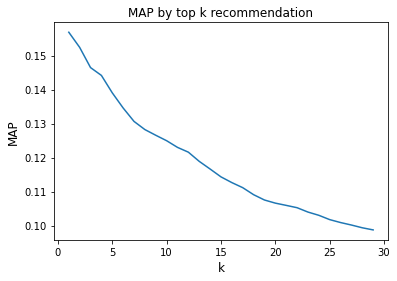

In [80]:
plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()